# The Character of Italian Cities

## Idea
The idea is to cluster italian cities using the Foursquare data and to see if the clustering is able to grasp their *character*. Cities are commonly classified industrial, commercial and agricultural cities. In Italy tourism is also very important. Tourism may be related to cultural heritage, the presence of beautiful sea or mountains, but also very important in Italy is food tourism. We will see if the clustering reflects some of these classifications or not.

## Backgroung

Cities are towns with more than 50 thousands inhabitants. Italian cities are small (see [this wikipedia link](https://en.wikipedia.org/wiki/List_of_cities_in_Italy)): the most pupulated city is Rome, the capital city, with population close to 3 millions. Then comes Milan, the economic capital, with a population of less than 1.5 millios. The population of all the other italian cities is below 1 million, with only 15 cities above 200 thousands and the remaing 130 some cites with less inhabitants.

## Stakeholders

This is a very general study, so it may be of interest for several categories of stakeholders and at the same time it is not specifically aimed at any of these:
- Tourists: suppose you have a list of your preferred italian cities and you want to visit another Italian city. Then you can chose among the cites similar to your preferred ones.
- Investors: suppose you did investments in italian cities. Some of them went very well, some others went less well. If you want to want to invest other money you may chose the cities having a similar *character* as those were you did the best money.

## Imports

In [1]:
import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter # set a delay between geopy calls

import folium # map rendering library

import requests # library to handle requests (here for Foursquare API)

from sklearn.cluster import KMeans # k-means clustering

# Colors
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

## Functions
Here we define the custom functions for this notebook.

### get_cetegories - get_subcategories
The categories of Foursquares venues are organized in a tree, which is reported in [this](https://developer.foursquare.com/docs/resources/categories) page. This tree can be retrieved from a foursquare API call (`https://api.foursquare.com/v2/venues/categories`). We define two functions to manage the category tree (API call response):
- `get_categories` returns a a dictionary of the categories (id, name) pairs and is copied from [this](https://stackoverflow.com/questions/42914608/parse-nested-json-from-the-foursquare-api) StackOveflow questions.
- `get_subcategories` takes as input the name of a cetegory and the list of its subcategories and returns a dictionary of (id, name) pairs, where id is the id of a subcategory, while name is the provided name of the parent category. This function will allow to get the root category of each venue.

In [2]:
def get_categories(data):
    result = {}
    for cat in data:
        result[cat['id']] = cat['name']
        if cat['categories']:
            result.update(get_categories(cat['categories']))
    return result

def get_subcategories(data, name):
    # Input
    # - data The data relative to the subcategories of a given category in the Foursquare category tree (categories['response']['categories'])
    # - name The name of the main category
    # Output: a dictionary with
    # - keys The Ids of all the Foursquare subcategories of the category.
    # - values The name of the given category (as in the input). 
    result = {}
    for cat in data:
        result[cat['id']] = name
        if cat['categories']:
            result.update(get_subcategories(cat['categories'], name))
    return result

### getNearbyVenues
A function to fetch from Foursquares the venues nearby a series of places:

In [3]:
def getNearbyVenues(CLIENT_ID, CLIENT_SECRET, VERSION, names, latitudes, longitudes, radius=2000, LIMIT=250):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'City', 
        'City Latitude', 
        'City Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude',
        'Venue Category ID',
        'Venue Category Name'
    ]
    
    return(nearby_venues)

## List of Italian cities

We will take the list of italian cities (i.e. having more than 50000 inhabitants) from [this wikipedia page](https://it.wikipedia.org/wiki/Comuni_d%27Italia_per_popolazione). It is a page of the italian version of Wikipedia, because the English version linked above doesn't provide enough information (in particular doesn't report the province) to get the latitutde and longitude with `geocoder`.

We will use `pandas` to scrape the wikipedia page:

In [4]:
it_city_raw = pd.read_html('https://it.wikipedia.org/wiki/Comuni_d%27Italia_per_popolazione')[0]

In [5]:
it_city_raw.columns = ['Rank', 'City', 'Region', 'Province', 'Population']

The wikipedia table list the italian cities in order of population starting from the most populated. We have already changed the columns names into the english version. The colunms are:
- **Rank**. The rank of the city according to its population.
- **City**. The (Italian) name of the city.
- **Region**. Italy is subdivided in 21 regions. The column reports which region the city belongs to.
- **Province**. Italian regions are further subdivided into provinces. The column report the province of the city.
- **Population**. The population of the city.

In [6]:
it_city_raw.head()

,Rank,City,Region,Province,Population
0,1,Roma,Lazio,Roma,2 849 032
1,2,Milano,Lombardia,Milano,1 387 171
2,3,Napoli,Campania,Napoli,955 542
3,4,Torino,Piemonte,Torino,874 935
4,5,Palermo,Sicilia,Palermo,660 263


We conver the **Population** column to *numeric*:

In [7]:
# First we convert the Population row from string to numeric
it_city = it_city_raw
it_city['Population'] = pd.to_numeric(it_city['Population'].str.replace(" ","")) # .str.replace(" ","") removes the spaces

Head and tail of the Cities dataframe

In [8]:
it_city.head()

,Rank,City,Region,Province,Population
0,1,Roma,Lazio,Roma,2849032
1,2,Milano,Lombardia,Milano,1387171
2,3,Napoli,Campania,Napoli,955542
3,4,Torino,Piemonte,Torino,874935
4,5,Palermo,Sicilia,Palermo,660263


In [9]:
it_city.tail()

,Rank,City,Region,Province,Population
141,142,Chieti,Abruzzo,Chieti,50646
142,143,Rho,Lombardia,Milano,50602
143,144,Scandicci,Toscana,Firenze,50551
144,145,Scafati,Campania,Salerno,50516
145,146,Misterbianco,Sicilia,Catania,50037


## Cohordinates of italian cities

Now we use the `geocoder` package to get the latitude and longitude of the cities. We will follow the procedure desctibed in [this](https://towardsdatascience.com/geocode-with-python-161ec1e62b89) *TowardDataScience* page.

Get the cohordinates of Rome, the capital city, which is close to the middle of the country.

In [10]:
address = 'Rome, Rome, IT'

geolocator = Nominatim(user_agent="it_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Rome are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Rome are 41.894802, 12.4853384.


Add the latitude and longitude to the cities dataframe

In [11]:
# Limit the rate of calls to geopy (THIS WAS NOT USED)
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Create the address as [City], [Province], IT
address = it_city['City'] + ', ' + it_city['Province'] + ', IT'

# Call to geopy
location = address.apply(geolocator.geocode, timeout=15)

In [12]:
it_city['Latitude']=location.apply(lambda loc: loc.latitude)
it_city['Longitude']=location.apply(lambda loc: loc.longitude)

it_city.head()

,Rank,City,Region,Province,Population,Latitude,Longitude
0,1,Roma,Lazio,Roma,2849032,41.894802,12.485338
1,2,Milano,Lombardia,Milano,1387171,45.466800,9.190500
2,3,Napoli,Campania,Napoli,955542,40.835934,14.248783
3,4,Torino,Piemonte,Torino,874935,45.067755,7.682489
4,5,Palermo,Sicilia,Palermo,660263,38.111227,13.352443


The latitude and longitude of a few cities was not correct. We adjust it manually:

In [13]:
it_city.loc[ it_city['City']=="Andria", ["Latitude","Longitude"]] = [41.22535,16.29588]
it_city.loc[ it_city['City']=="Guidonia Montecelio", ["Latitude","Longitude"]] = [41.99756, 12.72598]
it_city.loc[ it_city['City']=="Corigliano-Rossano", ["Latitude","Longitude"]] = [39.5994, 16.6323]
it_city.loc[ it_city['City']=="Casoria", ["Latitude","Longitude"]] = [40.90553,14.29055]
it_city.loc[ it_city['City']=="Gela", ["Latitude","Longitude"]] = [37.06650,14.25028]
it_city.loc[ it_city['City']=="Lamezia Terme", ["Latitude","Longitude"]] = [38.96293, 16.30932]
it_city.loc[ it_city['City']=="Quartu Sant'Elena", ["Latitude","Longitude"]] = [39.2402, 9.1858]
it_city.loc[ it_city['City']=="Crotone", ["Latitude","Longitude"]] = [39.08060,17.12720]
it_city.loc[ it_city['City']=="Afragola", ["Latitude","Longitude"]] = [40.92589,14.30993]
it_city.loc[ it_city['City']=="Vittoria", ["Latitude","Longitude"]] = [36.95188,14.52986]
it_city.loc[ it_city['City']=="Carrara", ["Latitude","Longitude"]] = [44.07874,10.10028]
it_city.loc[ it_city['City']=="Caltanissetta", ["Latitude","Longitude"]] = [37.49028,14.06069]
it_city.loc[ it_city['City']=="Olbia", ["Latitude","Longitude"]] = [40.92391,9.50049]
it_city.loc[ it_city['City']=="Marano di Napoli", ["Latitude","Longitude"]] = [40.89808,14.19073]
it_city.loc[ it_city['City']=="Cerignola", ["Latitude","Longitude"]] = [41.26479,15.89968]
it_city.loc[ it_city['City']=="Manfredonia", ["Latitude","Longitude"]] = [41.62521,15.90873]
it_city.loc[ it_city['City']=="San Severo", ["Latitude","Longitude"]] = [41.68847,15.37958]
it_city.loc[ it_city['City']=="Chieti", ["Latitude","Longitude"]] = [42.3551,14.1582]
it_city.loc[ it_city['City']=="Misterbianco", ["Latitude","Longitude"]] = [37.52028,15.00639]

In [14]:
it_city.loc[ it_city['City'].isin([
    "Andria", "Guidonia Montecelio", "Corigliano-Rossano", "Casoria", "Gela",
    "Lamezia Terme", "Quartu Sant'Elena", "Crotone", "Afragola", "Vittoria",
    "Carrara", "Caltanissetta", "Olbia", "Marano di Napoli", "Cerignola",
    "Manfredonia", "San Severo", "Chieti", "Misterbianco"
]),]

,Rank,City,Region,Province,Population,Latitude,Longitude
45,46,Andria,Puglia,Barletta-Andria-Trani,99671,41.22535,16.29588
55,56,Guidonia Montecelio,Lazio,Roma,89671,41.99756,12.72598
70,71,Corigliano-Rossano,Calabria,Cosenza,77128,39.59940,16.63230
71,72,Casoria,Campania,Napoli,76791,40.90553,14.29055
76,77,Gela,Sicilia,Caltanissetta,73854,37.06650,14.25028
82,83,Lamezia Terme,Calabria,Catanzaro,70598,38.96293,16.30932
83,84,Quartu Sant'Elena,Sardegna,Cagliari,70531,39.24020,9.18580
92,93,Crotone,Calabria,Crotone,64710,39.08060,17.12720
93,94,Afragola,Campania,Napoli,64443,40.92589,14.30993
94,95,Vittoria,Sicilia,Ragusa,64040,36.95188,14.52986


## Visualize the cities with folium

In [15]:
it_map = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, label in zip(it_city['Latitude'], it_city['Longitude'], it_city['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(it_map)  
    
it_map

## Get the root category of each Foursquares category
Foursquares categories are organized in a tree with 10 base or *root* categories:
1. 'Arts & Entertainment',
2. 'College & University',
3. 'Event',
4. 'Food',
5. 'Nightlife Spot',
6. 'Outdoors & Recreation',
7. 'Professional & Other Places',
8. 'Residence',
9. 'Shop & Service',
10. 'Travel & Transport'
All other categories are subcategories of these 10 root categories. For example *Jazz club* is a subcategory of the *Arts & Entertainment* category.

We will assign each venue to the root category containing the specific category of that venue: we aren't interested in the kind of restaurants that are present in a city, but we are interested in how many food places are there, comapered to the Arts and Entertainment places and so on. 

Import the user's Foursquare credentials

In [16]:
credentials = pd.read_csv('Foursquare_Credentials.csv')

CLIENT_ID = credentials.at[0, 'CLIENT_ID']
CLIENT_SECRET = credentials.at[0,'CLIENT_SECRET']
VERSION = '20191201' # Foursquare API version

Request the Foursquare venues categories tree

In [17]:
url='https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION
            )
categories = requests.get(url).json()

Create a dictionary with the IDs of all the Foursquare categories, paired with the name of the corresponding root category:

In [18]:
cat_rootcat={}

for cat in categories['response']['categories']:
    name=cat['name']
    cat_rootcat[cat['id']]=name
    if cat['categories']:
        cat_rootcat.update(get_subcategories(cat['categories'], name))

In [19]:
for x in list(cat_rootcat)[0:5]:
    print ("key: {}, value: {} ".format(x,  cat_rootcat[x]))

key: 4d4b7104d754a06370d81259, value: Arts & Entertainment 
key: 56aa371be4b08b9a8d5734db, value: Arts & Entertainment 
key: 4fceea171983d5d06c3e9823, value: Arts & Entertainment 
key: 4bf58dd8d48988d1e1931735, value: Arts & Entertainment 
key: 4bf58dd8d48988d1e2931735, value: Arts & Entertainment 


## Get the venues nearby each city center
We use the `getNearbyVenues` functions to retrive the popular venues nearby each city center:

In [20]:
it_venues = getNearbyVenues(
    CLIENT_ID=CLIENT_ID,
    CLIENT_SECRET=CLIENT_SECRET,
    VERSION=VERSION,    
    names=it_city['City'],
    latitudes=it_city['Latitude'],
    longitudes=it_city['Longitude'],
    radius=3000,
    LIMIT=100
)

Roma
Milano
Napoli
Torino
Palermo
Genova
Bologna
Firenze
Bari
Catania
Venezia
Verona
Messina
Padova
Trieste
Brescia
Parma
Taranto
Prato
Modena
Reggio Calabria
Reggio Emilia
Perugia
Livorno
Ravenna
Cagliari
Foggia
Rimini
Salerno
Ferrara
Sassari
Latina
Monza
Giugliano in Campania
Bergamo
Siracusa
Pescara
Trento
Forlì
Vicenza
Terni
Bolzano
Novara
Piacenza
Ancona
Andria
Udine
Arezzo
Cesena
Lecce
Pesaro
Barletta
Alessandria
La Spezia
Pistoia
Guidonia Montecelio
Catanzaro
Pisa
Lucca
Brindisi
Treviso
Torre del Greco
Busto Arsizio
Marsala
Como
Grosseto
Sesto San Giovanni
Pozzuoli
Varese
Fiumicino
Corigliano-Rossano
Casoria
Asti
Cinisello Balsamo
Caserta
Aprilia
Gela
Ragusa
Pavia
Cremona
Carpi
Altamura
Lamezia Terme
Quartu Sant'Elena
Imola
L'Aquila
Massa
Viterbo
Trapani
Cosenza
Potenza
Castellammare di Stabia
Crotone
Afragola
Vittoria
Pomezia
Vigevano
Carrara
Viareggio
Caltanissetta
Fano
Olbia
Legnano
Savona
Matera
Marano di Napoli
Molfetta
Benevento
Agrigento
Acerra
Faenza
Cerignola
Moncalieri

In [21]:
it_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category ID,Venue Category Name
0,Roma,41.894802,12.485338,Foro di Traiano,41.894729,12.484871,4deefb944765f83613cdba6e,Historic Site
1,Roma,41.894802,12.485338,Foro di Cesare,41.894128,12.485232,4deefb944765f83613cdba6e,Historic Site
2,Roma,41.894802,12.485338,Zuil van Trajanus (Colonna Traiana),41.895816,12.484276,4bf58dd8d48988d12d941735,Monument / Landmark
3,Roma,41.894802,12.485338,Terrazza delle Quadrighe,41.894346,12.483336,4bf58dd8d48988d165941735,Scenic Lookout
4,Roma,41.894802,12.485338,Piazza Venezia,41.895747,12.482446,4bf58dd8d48988d164941735,Plaza


Get the root category of each venue:

In [22]:
it_venues['Venue Root Category']=[cat_rootcat[x] for x in it_venues['Venue Category ID']]
it_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category ID,Venue Category Name,Venue Root Category
0,Roma,41.894802,12.485338,Foro di Traiano,41.894729,12.484871,4deefb944765f83613cdba6e,Historic Site,Arts & Entertainment
1,Roma,41.894802,12.485338,Foro di Cesare,41.894128,12.485232,4deefb944765f83613cdba6e,Historic Site,Arts & Entertainment
2,Roma,41.894802,12.485338,Zuil van Trajanus (Colonna Traiana),41.895816,12.484276,4bf58dd8d48988d12d941735,Monument / Landmark,Professional & Other Places
3,Roma,41.894802,12.485338,Terrazza delle Quadrighe,41.894346,12.483336,4bf58dd8d48988d165941735,Scenic Lookout,Outdoors & Recreation
4,Roma,41.894802,12.485338,Piazza Venezia,41.895747,12.482446,4bf58dd8d48988d164941735,Plaza,Outdoors & Recreation


Get the number of venues returned by the API for each city:

In [23]:
it_venues_counts = it_venues['City'].value_counts()
it_venues_counts.head()

Palermo    100
Treviso    100
Brescia    100
Lucca      100
Legnano    100
Name: City, dtype: int64

In [24]:
it_venues_counts.tail(20)

Catanzaro              15
Aprilia                15
Andria                 14
Teramo                 12
Caltanissetta           9
Marano di Napoli        9
Misterbianco            9
Manfredonia             8
Bitonto                 8
Velletri                8
Afragola                8
Vittoria                7
Guidonia Montecelio     7
Carrara                 7
Gela                    6
Corigliano-Rossano      6
Lamezia Terme           6
Crotone                 5
San Severo              4
Cerignola               4
Name: City, dtype: int64

We feel that we don't have enough data for some cities, so we will remove some from the clustering analysis

In [25]:
min_venues = 15
cities_to_exclude = it_venues_counts.index[ it_venues_counts < min_venues ]
cities_to_exclude

Index(['Andria', 'Teramo', 'Caltanissetta', 'Marano di Napoli', 'Misterbianco',
       'Manfredonia', 'Bitonto', 'Velletri', 'Afragola', 'Vittoria',
       'Guidonia Montecelio', 'Carrara', 'Gela', 'Corigliano-Rossano',
       'Lamezia Terme', 'Crotone', 'San Severo', 'Cerignola'],
      dtype='object')

In [26]:
it_venues_all = it_venues
it_venues = it_venues[~(it_venues['City'].isin( cities_to_exclude ))]

Now we want to see how the venues of each city are distributed among the 10 main (root) venue categories. This is a two steps procedure:
1. One hot encoding.
2. Group by city.

One hot encoding the `Venue Root Catogory` column.

In [27]:
it_venues_onehot = it_venues[['City']].merge(
    pd.get_dummies(it_venues['Venue Root Category']),
    left_index=True, right_index=True,
    suffixes=('', ' Category')
)

In [28]:
it_venues_onehot.head()

,City,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Roma,1,0,0,0,0,0,0,0
1,Roma,1,0,0,0,0,0,0,0
2,Roma,0,0,0,0,0,1,0,0
3,Roma,0,0,0,0,1,0,0,0
4,Roma,0,0,0,0,1,0,0,0


Get the distribution of root categories for each city.

This is done just by grouping by city and getting the mean of each group: as each row of the one-hot-encoded dataframe adds up to 1, also their mean will add up to 1, hence representing a distribution.

In [29]:
it_city_venues = it_venues_onehot.groupby('City').mean().reset_index()

In [30]:
it_city_venues.head()

,City,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Acerra,0.105263,0.0,0.315789,0.000000,0.000000,0.0000,0.473684,0.105263
1,Acireale,0.018519,0.0,0.537037,0.092593,0.203704,0.0000,0.055556,0.092593
2,Agrigento,0.200000,0.0,0.600000,0.088889,0.000000,0.0000,0.022222,0.088889
3,Alessandria,0.053571,0.0,0.625000,0.071429,0.089286,0.0000,0.125000,0.035714
4,Altamura,0.000000,0.0,0.562500,0.125000,0.125000,0.0625,0.062500,0.062500


In [31]:
it_city_venues.describe()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.070537,0.000404,0.529590,0.097841,0.111942,0.011601,0.113150,0.064934
std,0.040469,0.002433,0.082641,0.060134,0.055178,0.019043,0.082476,0.050241
min,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.043025,0.000000,0.480000,0.057637,0.071071,0.000000,0.054302,0.027127
50%,0.067606,0.000000,0.538633,0.090000,0.111452,0.000000,0.096875,0.057916
75%,0.100000,0.000000,0.583567,0.129559,0.140000,0.020000,0.154447,0.094285
max,0.200000,0.021739,0.800000,0.370370,0.370370,0.110000,0.473684,0.282609


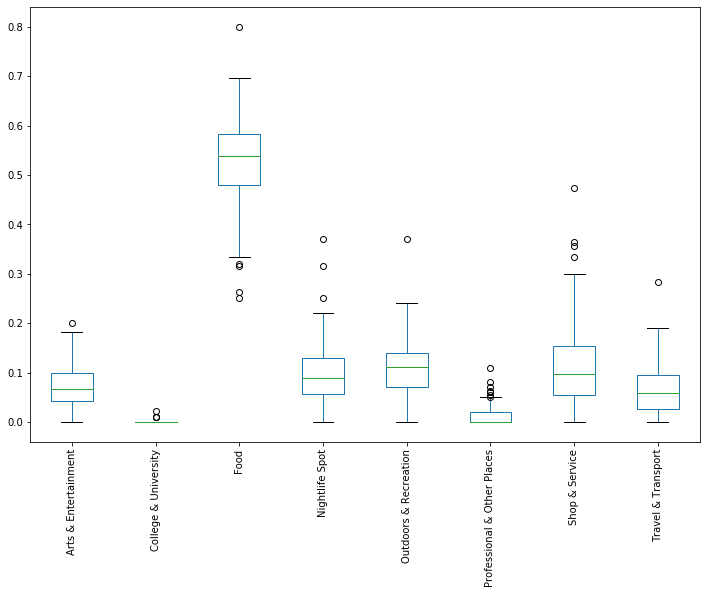

In [32]:
it_city_venues.plot(kind='box', figsize=(12, 8), rot=90)

## Clustering



In [347]:
# set number of clusters
kclusters = 5

it_city_clustering = it_city_venues.set_index('City')

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(it_city_clustering)

In [348]:
it_city_clustering['Cluster'] = kmeans.labels_

In [349]:
it_city_clustering.reset_index(inplace=True)

In [350]:
it_city_clustering['Cluster'].value_counts()

3    36
1    32
2    26
0    25
4     8
Name: Cluster, dtype: int64

In [351]:
it_city_clustering

,City,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
0,Acerra,0.117647,0.0,0.0,0.294118,0.000000,0.000000,0.000000,0.529412,0.058824,4
1,Acireale,0.033333,0.0,0.0,0.500000,0.083333,0.183333,0.000000,0.083333,0.116667,0
2,Agrigento,0.200000,0.0,0.0,0.600000,0.088889,0.022222,0.000000,0.022222,0.066667,3
3,Alessandria,0.055556,0.0,0.0,0.611111,0.074074,0.092593,0.000000,0.129630,0.037037,3
4,Altamura,0.000000,0.0,0.0,0.555556,0.111111,0.166667,0.055556,0.055556,0.055556,2
...,...,...,...,...,...,...,...,...,...,...,...
122,Verona,0.080000,0.0,0.0,0.570000,0.100000,0.120000,0.050000,0.040000,0.040000,3
123,Viareggio,0.013699,0.0,0.0,0.630137,0.095890,0.164384,0.013699,0.027397,0.054795,3
124,Vicenza,0.100000,0.0,0.0,0.570000,0.130000,0.080000,0.020000,0.080000,0.020000,3
125,Vigevano,0.043478,0.0,0.0,0.521739,0.043478,0.108696,0.021739,0.239130,0.021739,1


Merge the datframe giving the position of the cities, with that giving the cluster

In [352]:
it_city_final = it_city.merge(
    it_city_clustering,
    on="City"
)

We will plot in the map also the cities excluded from clustering, using a grey color.

In [359]:
it_city_excluded = it_city[ it_city['City'].isin( cities_to_exclude ) ]

Visualize the clustering

In [361]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map, colored according to the cluster
for lat, lon, poi, cluster in zip(it_city_final['Latitude'], it_city_final['Longitude'], it_city_final['City'], it_city_final['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# add grey empty merkers for the cities excluded from the clustering
for lat, lon, poi in zip(it_city_excluded['Latitude'], it_city_excluded['Longitude'], it_city_excluded['City']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='#808080',
        fill=False).add_to(map_clusters)

map_clusters

### Interpreting clusters

In [362]:
it_city_cmeans = it_city_clustering.drop('City', axis=1).groupby('Cluster').mean()

In [363]:
it_city_cmeans

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Cluster,,,,,,,,,
0,0.094511,0.000000,0.000000,0.482936,0.078997,0.155333,0.016754,0.049971,0.121498
1,0.065928,0.000727,0.000000,0.523497,0.073190,0.104321,0.008863,0.170153,0.053321
2,0.059790,0.000385,0.000000,0.515929,0.172181,0.119877,0.010284,0.078633,0.042920
3,0.063726,0.000278,0.000278,0.613360,0.085849,0.100067,0.010834,0.076958,0.048651
4,0.071565,0.001250,0.000000,0.382882,0.048212,0.087477,0.010156,0.300893,0.097565


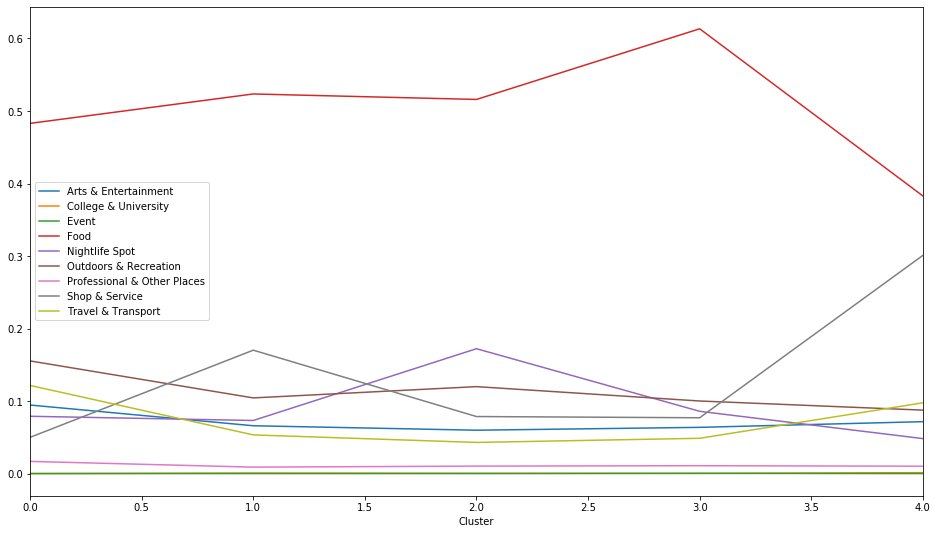

In [364]:
%matplotlib inline
it_city_cmeans.plot(figsize=(16, 9))

The abscissa is the cluster (0, 1, 2, 3 or 4). The principal venue category for all the clusters is 'Food'. What changes is who comes second after food:
- Cluster 0 (Violet on the map) who comes second is Outdoors & Recreation, meaning that there are several opportunies for exploring natural beauties.
- Cluster 1 (Cyan on the map) Shops & Services is the second most important category here. Should be a good city to eat and buy tipical italian stuff.
- Cluster 2 (Green on the map) cites have a lot of Nightlife spots: are perfect for night life!
- Cluster 3 (Red on the map). I would say food and food again. You can only eat here.
- Cluster 4 (Orange on the map). These cities are very filled with shops, so much that the number of Food places is below the average.